In [46]:
import pandas as pd
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from modelling import plot_loss_accuracy_curves, evaluation_metrics

In [2]:
data_dir = "..\\..\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images
dest_dir = "..\\..\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories
df = pd.read_csv("..\\..\\DATA\\HAM10000_metadata")  # read metadata
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [3]:
df = df[df["diagnosis"].isin(["nv", "bcc", "bkl", "mel"])]

In [4]:
# Load original data
X = []
y = []

for index, row in df.iterrows():
    img_path = os.path.join(data_dir, row['image_id'] + '.jpg')
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    X.append(img_array)
    y.append(row['diagnosis'])

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
X.shape

(9431, 128, 128, 3)

In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=4)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)  # split images into test and train directories

In [9]:
class_counts = np.sum(y_train, axis=0)
class_counts = class_counts.astype(int)

In [10]:
max_images_per_class = 1000

In [11]:
sampling_strategy = {i: min(count, max_images_per_class) for i, count in enumerate(class_counts)}

In [12]:
pipeline = Pipeline([
    ("under", RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)),
    ("over", RandomOverSampler())
])

In [13]:
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2], X_train.shape[3])

In [14]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    vertical_flip=True,
    fill_mode="reflect"
)

test_datagen = ImageDataGenerator(rescale=1. / 255.)

In [15]:
train_data = train_datagen.flow(X_train_resampled, y_train_resampled, batch_size=32)
test_data = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [16]:
tf.random.set_seed(42)
model_a = Sequential(
    [Conv2D(filters=32,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3)),
     Conv2D(32, 3, activation="relu"),
     MaxPool2D(pool_size=2, padding="valid"),
     Conv2D(64, 3, activation="relu"),
     Conv2D(64, 3, activation="relu"),
     MaxPool2D(2),
     Conv2D(128, 3, activation="relu"),
     Conv2D(128, 3, activation="relu"),
     MaxPool2D(2),
     Flatten(),
     Dense(128, activation="relu"),
     Dense(4, activation="softmax")
     ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
model_a.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history_a = model_a.fit(train_data, epochs=10,
                        validation_data = test_data)

Epoch 1/10


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.2722 - loss: 1.3841 - val_accuracy: 0.5029 - val_loss: 0.9563
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 115s 913ms/step - accuracy: 0.4411 - loss: 1.1925 - val_accuracy: 0.4049 - val_loss: 1.1308
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 122s 972ms/step - accuracy: 0.4918 - loss: 1.1258 - val_accuracy: 0.6004 - val_loss: 0.9596
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5366 - loss: 1.0973 - val_accuracy: 0.5130 - val_loss: 0.9738
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 125s 979ms/step - accuracy: 0.5677 - loss: 1.0244 - val_accuracy: 0.5326 - val_loss: 0.9251
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 118s 938ms/step - accuracy: 0.5856 - loss: 1.0062 - val_accuracy: 0.5405 - val_loss: 1.0371
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 120s 954ms/step - accuracy: 0.5700 - loss: 0.9907 - val_accuracy: 0.5670 - val_loss: 0.8931
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 963ms/step - accuracy: 0.5933 - loss: 0.9909 - v

In [19]:
class_names = label_encoder.classes_

59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step


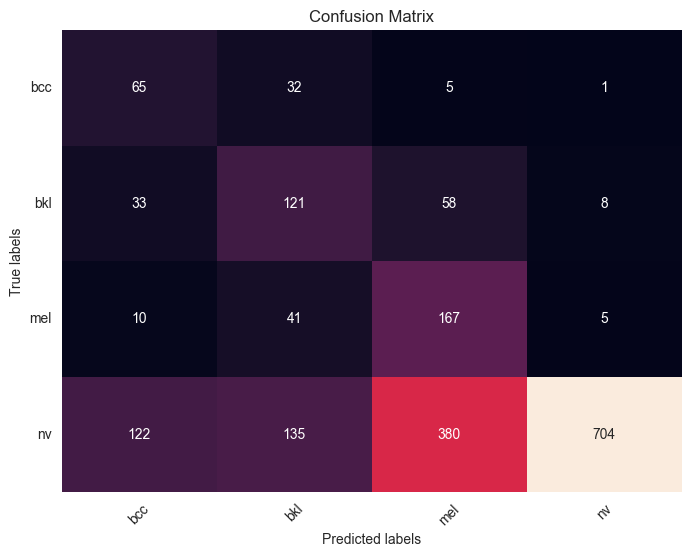

              precision    recall  f1-score   support

         bcc       0.28      0.63      0.39       103
         bkl       0.37      0.55      0.44       220
         mel       0.27      0.75      0.40       223
          nv       0.98      0.52      0.68      1341

    accuracy                           0.56      1887
   macro avg       0.48      0.61      0.48      1887
weighted avg       0.79      0.56      0.61      1887


In [20]:
evaluation_metrics(model_a, test_data, y_test, class_names)

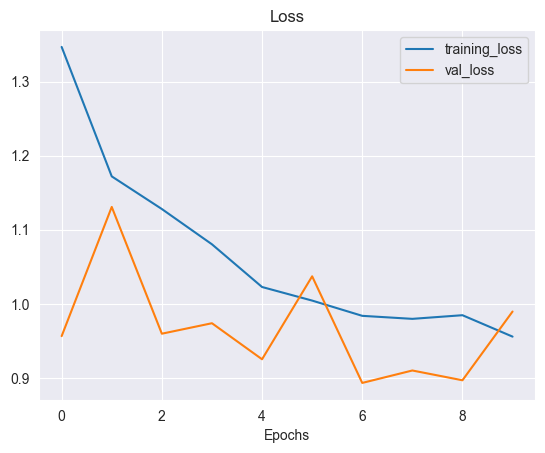

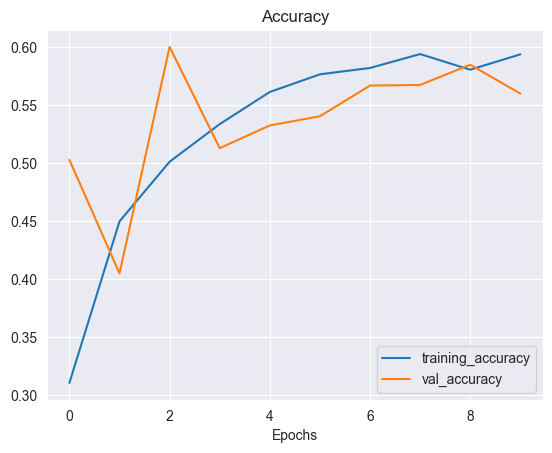

In [21]:
plot_loss_accuracy_curves(history_a)

In [22]:
model_2 = Sequential(
    [Conv2D(filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3)),
     Conv2D(64,3,activation="relu"),
     MaxPool2D(pool_size=2, padding="valid"),
     Conv2D(128,3,activation="relu"),
     Conv2D(128,3,activation="relu"),
     MaxPool2D(2),
     Conv2D(256,3,activation="relu"),
     Conv2D(256,3, activation="relu"),
     Conv2D(256,3,activation="relu"),
     MaxPool2D(2),
     Conv2D(512,3,activation="relu"),
     Conv2D(512,3, activation="relu"),
     Conv2D(512,3,activation="relu"),
     MaxPool2D(2),
     Flatten(),
     Dense(512, activation="relu"),
     Dropout(0.3),
     Dense(512, activation="relu"),
     Dense(4, activation="softmax")
     ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [23]:
model_2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(train_data, epochs=10,
                        validation_data=test_data)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.2532 - loss: 1.3872 - val_accuracy: 0.1182 - val_loss: 1.3980
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 542s 4s/step - accuracy: 0.2426 - loss: 1.3866 - val_accuracy: 0.0546 - val_loss: 1.3900
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.2280 - loss: 1.3866 - val_accuracy: 0.1166 - val_loss: 1.3912
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.2480 - loss: 1.3864 - val_accuracy: 0.7107 - val_loss: 1.3859
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.2508 - loss: 1.3865 - val_accuracy: 0.1166 - val_loss: 1.3846
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.2576 - loss: 1.3863 - val_accuracy: 0.0546 - val_loss: 1.3872
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - accuracy: 0.2364 - loss: 1.3864 - val_accuracy: 0.0546 - val_loss: 1.3864
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.2512 - loss: 1.3864 - val_accu

59/59 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step


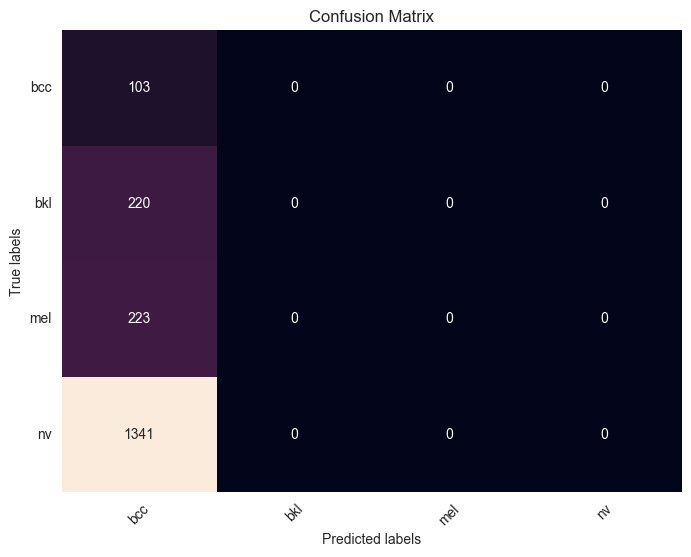

              precision    recall  f1-score   support

         bcc       0.05      1.00      0.10       103
         bkl       0.00      0.00      0.00       220
         mel       0.00      0.00      0.00       223
          nv       0.00      0.00      0.00      1341

    accuracy                           0.05      1887
   macro avg       0.01      0.25      0.03      1887
weighted avg       0.00      0.05      0.01      1887


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [24]:
evaluation_metrics(model_2, test_data, y_test, class_names)

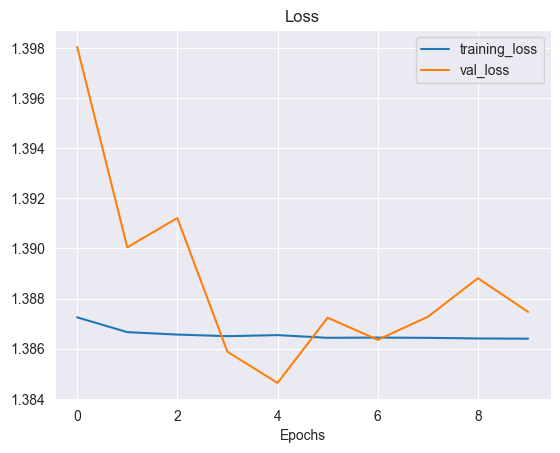

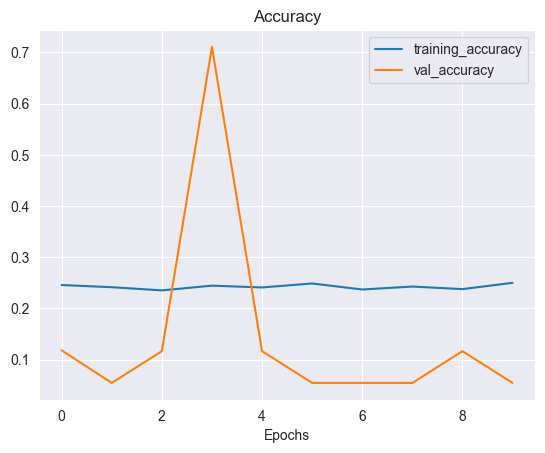

In [25]:
plot_loss_accuracy_curves(history_2)

In [26]:
model_3 = Sequential(
    [Conv2D(filters=64,
            kernel_size=3,
            activation="relu",
            input_shape=(128, 128, 3)),
     Conv2D(64,3,activation="relu"),
     MaxPool2D(pool_size=2, padding="valid"),
     Conv2D(128,3,activation="relu"),
     Conv2D(128,3,activation="relu"),
     MaxPool2D(2),
     Conv2D(256,3,activation="relu"),
     Conv2D(256,3, activation="relu"),
     Conv2D(256,3,activation="relu"),
     MaxPool2D(2),
     Conv2D(512,3,activation="relu"),
     Conv2D(512,3, activation="relu"),
     Conv2D(512,3,activation="relu"),
     MaxPool2D(2),
     Flatten(),
     Dense(512, activation="relu"),
     Dropout(0.5),  
     Dense(512, activation="relu"),
     Dropout(0.5),  
     Dense(256, activation="relu"),  
     Dropout(0.5),  
     Dense(4, activation="softmax")
     ]
)

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [27]:
model_3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - accuracy: 0.2604 - loss: 1.3849 - val_accuracy: 0.7107 - val_loss: 1.3701
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 492s 4s/step - accuracy: 0.2481 - loss: 1.3861 - val_accuracy: 0.4844 - val_loss: 1.2033
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.3892 - loss: 1.2563 - val_accuracy: 0.6884 - val_loss: 0.8757
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.4320 - loss: 1.1760 - val_accuracy: 0.6693 - val_loss: 0.8772
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.4220 - loss: 1.1501 - val_accuracy: 0.5962 - val_loss: 1.0792
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.4566 - loss: 1.1405 - val_accuracy: 0.6269 - val_loss: 0.9337
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 497s 4s/step - accuracy: 0.4744 - loss: 1.1088 - val_accuracy: 0.5109 - val_loss: 1.0532
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.4987 - loss: 1.0878 - val_accu

In [28]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [29]:
for layer in base_model.layers:
    layer.trainable = False

In [30]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x) 
x = layers.Dropout(0.5)(x)  
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dense(4, activation='softmax')(x)  

In [31]:
model_4 = tf.keras.models.Model(inputs=base_model.input, outputs=x)

In [32]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [33]:
history_4 = model_4.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.3636 - loss: 1.6986 - val_accuracy: 0.6116 - val_loss: 0.9885
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5070 - loss: 1.1266 - val_accuracy: 0.6163 - val_loss: 0.9391
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - accuracy: 0.5201 - loss: 1.0910 - val_accuracy: 0.6836 - val_loss: 0.8255
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.5209 - loss: 1.1055 - val_accuracy: 0.6513 - val_loss: 0.8834
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.5191 - loss: 1.0919 - val_accuracy: 0.6116 - val_loss: 0.9374
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.5377 - loss: 1.0730 - val_accuracy: 0.6275 - val_loss: 0.8945
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.5020 - loss: 1.1093 - val_accuracy: 0.6630 - val_loss: 0.7905
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.5318 - loss: 1.0608 - val_accu

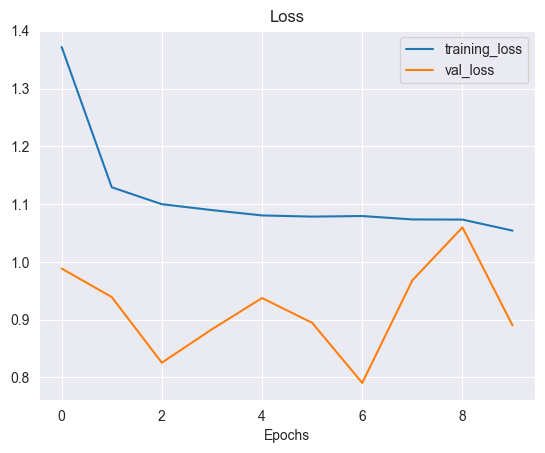

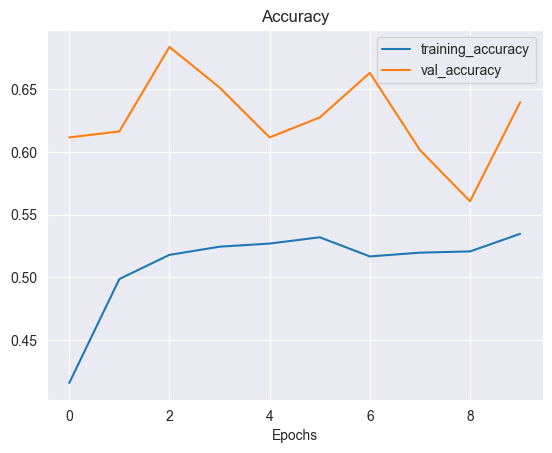

In [35]:
plot_loss_accuracy_curves(history_4)

59/59 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step


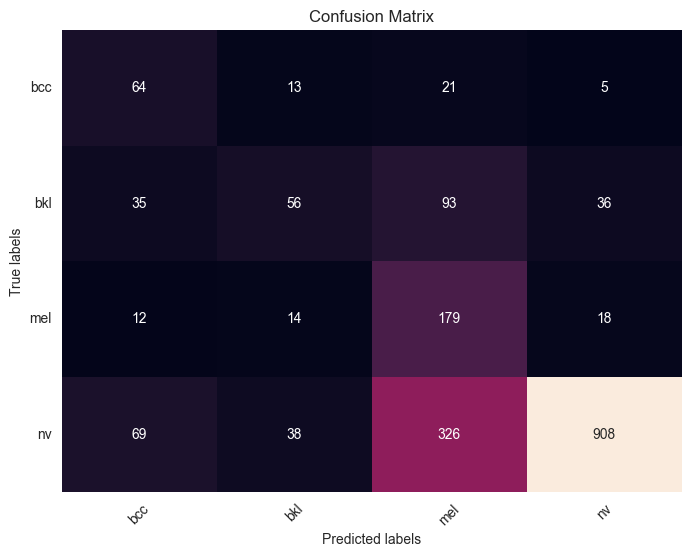

              precision    recall  f1-score   support

         bcc       0.36      0.62      0.45       103
         bkl       0.46      0.25      0.33       220
         mel       0.29      0.80      0.43       223
          nv       0.94      0.68      0.79      1341

    accuracy                           0.64      1887
   macro avg       0.51      0.59      0.50      1887
weighted avg       0.77      0.64      0.67      1887


In [36]:
evaluation_metrics(model_4, test_data, y_test, class_names)

In [39]:
model_b = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation="relu"),  
    Dense(4, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [40]:
model_b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b = model_b.fit(train_data, epochs=25, validation_data=test_data)

Epoch 1/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 239ms/step - accuracy: 0.3647 - loss: 1.3078 - val_accuracy: 0.5734 - val_loss: 0.9129
Epoch 2/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - accuracy: 0.5247 - loss: 1.1045 - val_accuracy: 0.5384 - val_loss: 1.0506
Epoch 3/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.5782 - loss: 1.0241 - val_accuracy: 0.6020 - val_loss: 0.8123
Epoch 4/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.5763 - loss: 1.0192 - val_accuracy: 0.5533 - val_loss: 0.9676
Epoch 5/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.5891 - loss: 0.9692 - val_accuracy: 0.4860 - val_loss: 1.1115
Epoch 6/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6080 - loss: 0.9387 - val_accuracy: 0.6312 - val_loss: 0.8118
Epoch 7/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.6224 - loss: 0.9094 - val_accuracy: 0.5951 - val_loss: 0.9160
Epoch 8/25
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6441 - loss: 0

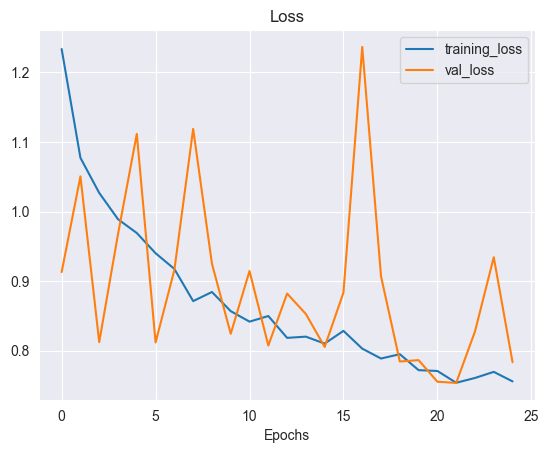

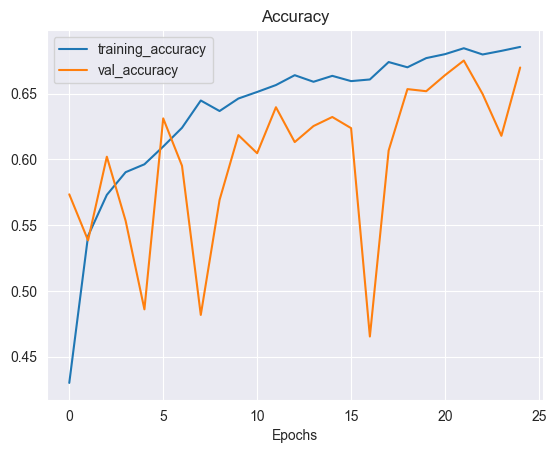

In [41]:
plot_loss_accuracy_curves(history_b)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


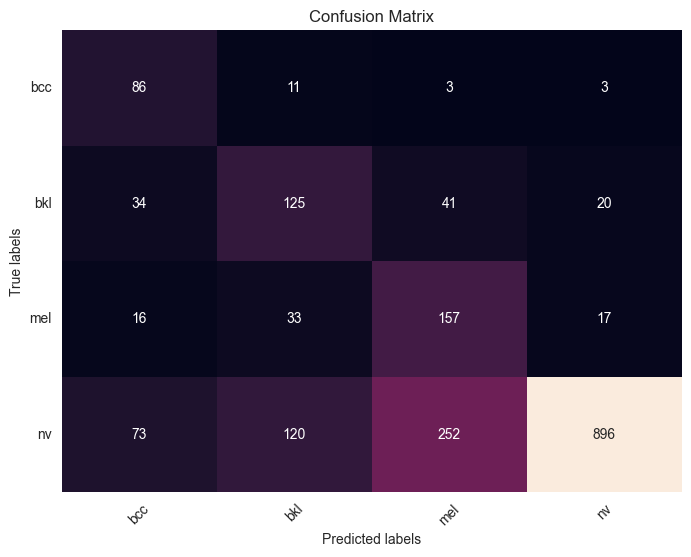

              precision    recall  f1-score   support

         bcc       0.41      0.83      0.55       103
         bkl       0.43      0.57      0.49       220
         mel       0.35      0.70      0.46       223
          nv       0.96      0.67      0.79      1341

    accuracy                           0.67      1887
   macro avg       0.54      0.69      0.57      1887
weighted avg       0.79      0.67      0.70      1887


In [42]:
evaluation_metrics(model_b, test_data, y_test, class_names)

In [43]:
model_c =  tf.keras.models.clone_model(model_a)

In [44]:
model_c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
history_c = model_c.fit(train_data, epochs=100, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 763ms/step - accuracy: 0.2374 - loss: 1.3933 - val_accuracy: 0.1182 - val_loss: 1.3447
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 785ms/step - accuracy: 0.3457 - loss: 1.2957 - val_accuracy: 0.5130 - val_loss: 1.0742
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 98s 775ms/step - accuracy: 0.4552 - loss: 1.1421 - val_accuracy: 0.4960 - val_loss: 1.0978
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 824ms/step - accuracy: 0.4709 - loss: 1.1415 - val_accuracy: 0.5548 - val_loss: 0.9219
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 773ms/step - accuracy: 0.4863 - loss: 1.1212 - val_accuracy: 0.5289 - val_loss: 0.9485
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 101s 801ms/step - accuracy: 0.5028 - loss: 1.0879 - val_accuracy: 0.5766 - val_loss: 0.8721
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 796ms/step - accuracy: 0.5126 - loss: 1.0807 - val_accuracy: 0.6216 - val_loss: 0.8267
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 100s 798ms/step - accuracy: 0.5

59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step


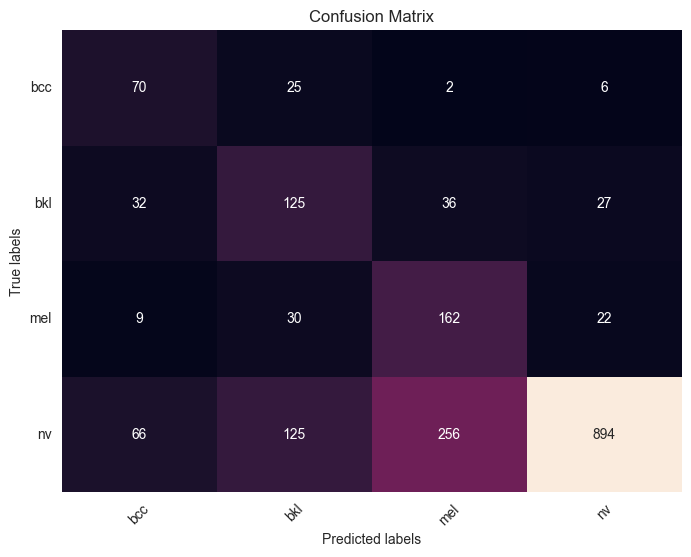

              precision    recall  f1-score   support

         bcc       0.40      0.68      0.50       103
         bkl       0.41      0.57      0.48       220
         mel       0.36      0.73      0.48       223
          nv       0.94      0.67      0.78      1341

    accuracy                           0.66      1887
   macro avg       0.53      0.66      0.56      1887
weighted avg       0.78      0.66      0.69      1887


In [49]:
evaluation_metrics(model_c, test_data, y_test, class_names)

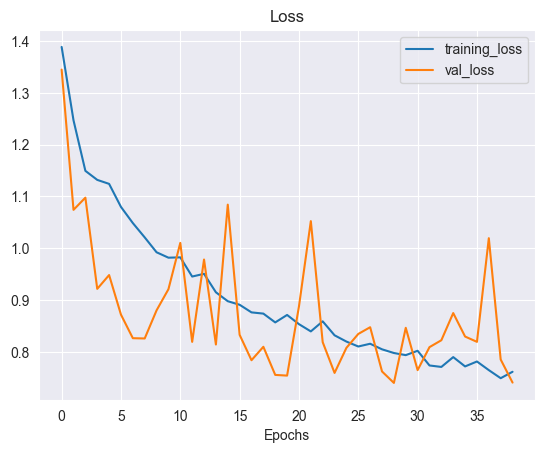

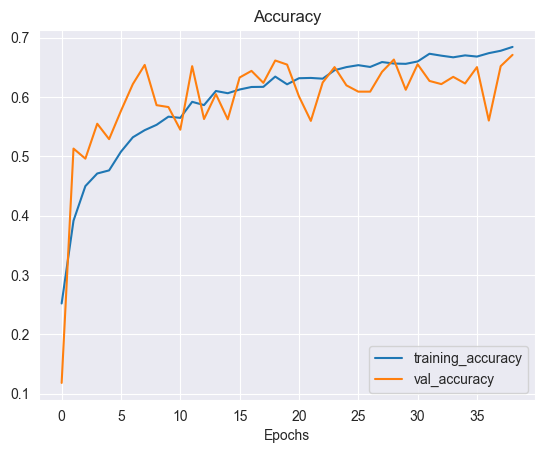

In [50]:
plot_loss_accuracy_curves(history_c)

In [51]:
model_d = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(20, 3, activation="relu"),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(30, 3, activation="relu"),
    Conv2D(30, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [52]:
model_d.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history_d = model_d.fit(train_data, epochs=100, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.2550 - loss: 1.3850 - val_accuracy: 0.1086 - val_loss: 1.3965
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.3220 - loss: 1.3594 - val_accuracy: 0.4526 - val_loss: 1.1751
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.4169 - loss: 1.2426 - val_accuracy: 0.5644 - val_loss: 0.9513
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step - accuracy: 0.4574 - loss: 1.1857 - val_accuracy: 0.5495 - val_loss: 0.9267
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.4930 - loss: 1.1387 - val_accuracy: 0.5575 - val_loss: 0.8979
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 203ms/step - accuracy: 0.5329 - loss: 1.0834 - val_accuracy: 0.5506 - val_loss: 0.9897
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.5404 - loss: 1.0910 - val_accuracy: 0.5639 - val_loss: 0.9075
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 207ms/step - accuracy: 0.5478 -

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


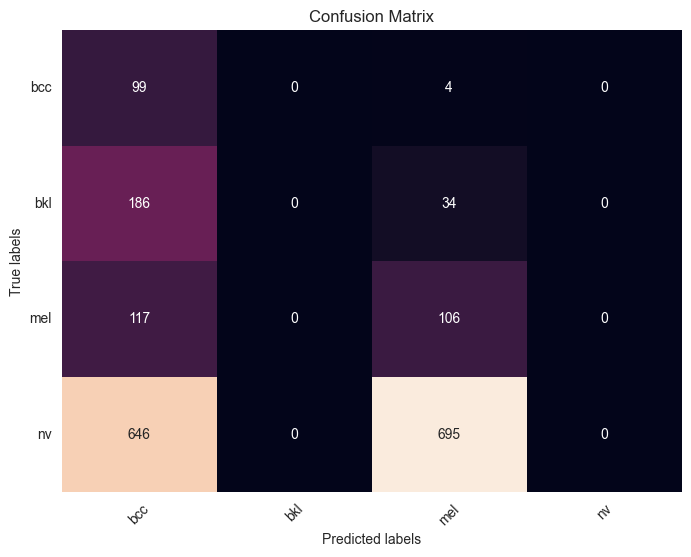

              precision    recall  f1-score   support

         bcc       0.09      0.96      0.17       103
         bkl       0.00      0.00      0.00       220
         mel       0.13      0.48      0.20       223
          nv       0.00      0.00      0.00      1341

    accuracy                           0.11      1887
   macro avg       0.06      0.36      0.09      1887
weighted avg       0.02      0.11      0.03      1887


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [54]:
evaluation_metrics(model_d, test_data, y_test, class_names)

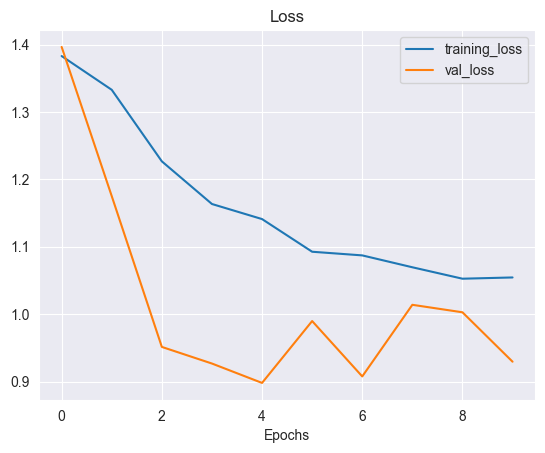

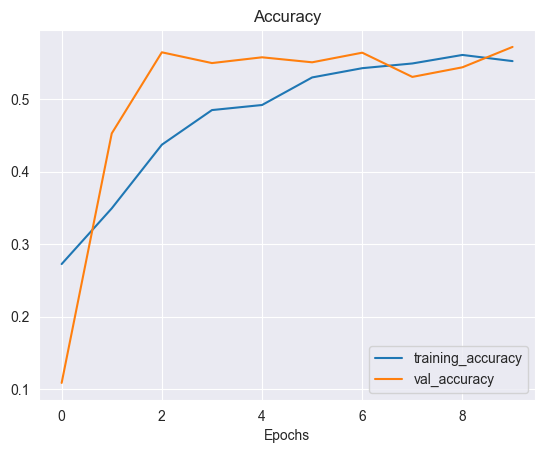

In [55]:
plot_loss_accuracy_curves(history_d)

In [56]:
model_e = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(128, 128, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2, padding="valid"),
    Conv2D(20, 3, activation="relu"),
    Conv2D(20, 3, activation="relu"),
    MaxPool2D(2),
    Conv2D(30, 3, activation="relu"),
    Conv2D(30, 3, activation="relu"),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(4, activation="softmax")
])

C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [57]:
model_e.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history_e = model_e.fit(train_data, epochs=100, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 213ms/step - accuracy: 0.3172 - loss: 1.3247 - val_accuracy: 0.5040 - val_loss: 1.0160
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.4515 - loss: 1.1597 - val_accuracy: 0.5326 - val_loss: 1.0041
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - accuracy: 0.4861 - loss: 1.1112 - val_accuracy: 0.4234 - val_loss: 1.1453
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.5324 - loss: 1.0603 - val_accuracy: 0.3471 - val_loss: 1.3295
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 207ms/step - accuracy: 0.5170 - loss: 1.1005 - val_accuracy: 0.5495 - val_loss: 0.9275
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 200ms/step - accuracy: 0.5708 - loss: 1.0037 - val_accuracy: 0.5946 - val_loss: 0.9416
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 207ms/step - accuracy: 0.5703 - loss: 1.0231 - val_accuracy: 0.5437 - val_loss: 0.8764
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.5811 -

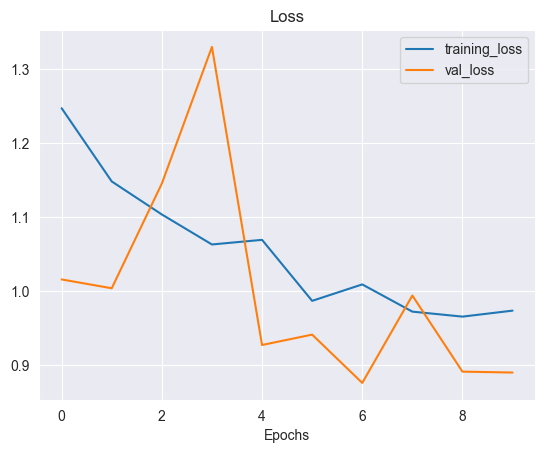

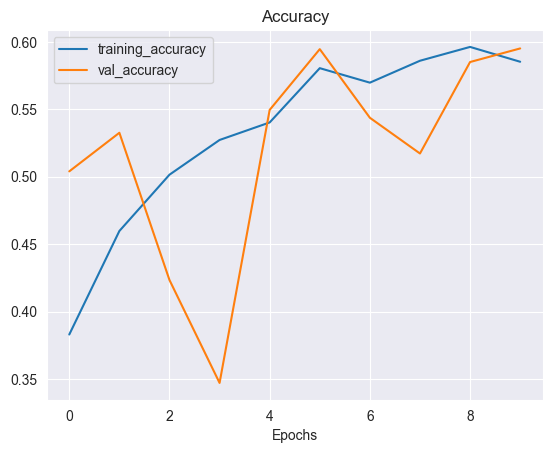

In [58]:
plot_loss_accuracy_curves(history_e)

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step


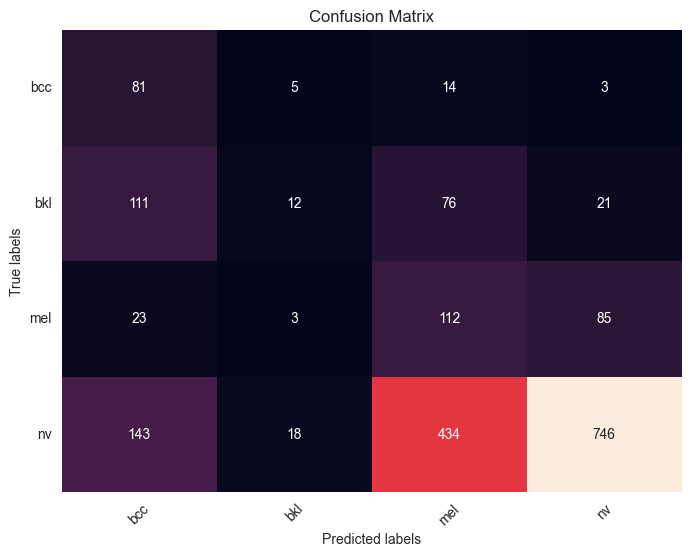

              precision    recall  f1-score   support

         bcc       0.23      0.79      0.35       103
         bkl       0.32      0.05      0.09       220
         mel       0.18      0.50      0.26       223
          nv       0.87      0.56      0.68      1341

    accuracy                           0.50      1887
   macro avg       0.40      0.47      0.35      1887
weighted avg       0.69      0.50      0.54      1887


In [59]:
evaluation_metrics(model_e, test_data, y_test, class_names)

In [60]:
model_5 = tf.keras.models.clone_model(model_2)
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history_5 = model_5.fit(train_data, epochs=100, validation_data=test_data, callbacks=[early_stopping])

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.2427 - loss: 1.3955 - val_accuracy: 0.1182 - val_loss: 1.3963
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.2422 - loss: 1.3958 - val_accuracy: 0.7107 - val_loss: 1.3603
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.2516 - loss: 1.3837 - val_accuracy: 0.7107 - val_loss: 1.3736
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.2595 - loss: 1.3863 - val_accuracy: 0.7107 - val_loss: 1.3081
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 480s 4s/step - accuracy: 0.2492 - loss: 1.3856 - val_accuracy: 0.7107 - val_loss: 1.3486
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.2690 - loss: 1.3790 - val_accuracy: 0.1346 - val_loss: 1.3761
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.3602 - loss: 1.2922 - val_accuracy: 0.6465 - val_loss: 1.0931
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.4377 - loss: 1.1886 - 

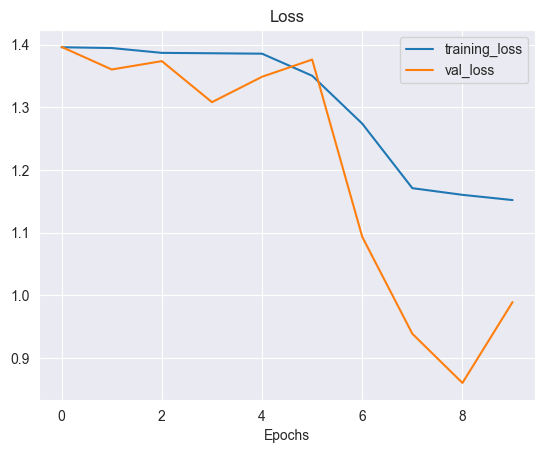

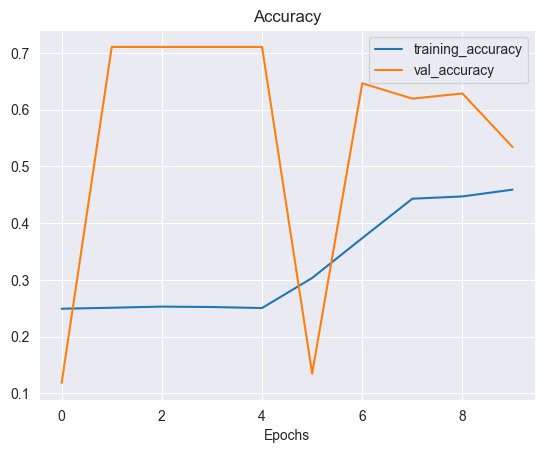

In [62]:
plot_loss_accuracy_curves(history_5)

59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


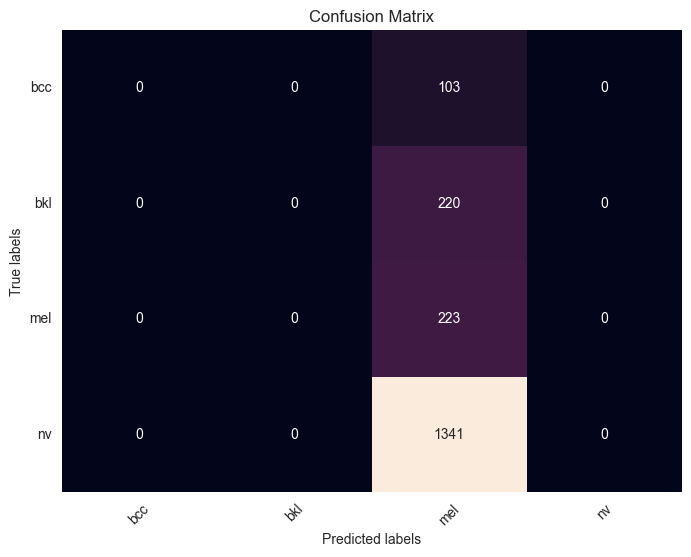

              precision    recall  f1-score   support

         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
         mel       0.12      1.00      0.21       223
          nv       0.00      0.00      0.00      1341

    accuracy                           0.12      1887
   macro avg       0.03      0.25      0.05      1887
weighted avg       0.01      0.12      0.02      1887


C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [63]:
evaluation_metrics(model_5, test_data, y_test, class_names)